<a href="https://colab.research.google.com/github/adeakinwe/computer_vision/blob/main/transfer_learning_without_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

In [2]:
def read_and_decode(filename, resize_dims):
    # 1. Read the raw file
    img_bytes = tf.io.read_file(filename)
    # 2. Decode image data
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    # 3. Convert pixel values to floats in [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize the image to match desired dimensions
    img = tf.image.resize(img, resize_dims)
    return img

In [3]:
def parse_csvline(csv_line):
    # record_defaults specify the data types for each column
    record_default = ["", ""]
    filename, label_string = tf.io.decode_csv(csv_line, record_default)

    # Load the image
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])

    # Convert label string to integer based on the CLASS_NAMES index
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

In [4]:
# Define datasets
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(8)
    .prefetch(tf.data.AUTOTUNE)
)

eval_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(8)
    .prefetch(tf.data.AUTOTUNE)
)

In [5]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),
    include_top = False,  #remove ImageNet head
    weights = "imagenet" #use pretrained weight
)

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
from tensorflow import keras

model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
])

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,509 (8.66 MB)

 Trainable params: 8,965 (35.02 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [7]:
# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # What to monitor ('val_loss' is common)
    patience=3,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

EPOCHS = 10

history = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/10
    413/Unknown 267s 620ms/step - accuracy: 0.6327 - loss: 1.0260

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


413/413 ━━━━━━━━━━━━━━━━━━━━ 299s 697ms/step - accuracy: 0.6329 - loss: 1.0253 - val_accuracy: 0.8351 - val_loss: 0.5096
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 211s 440ms/step - accuracy: 0.8462 - loss: 0.4503 - val_accuracy: 0.8351 - val_loss: 0.4976
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 198s 479ms/step - accuracy: 0.8881 - loss: 0.3302 - val_accuracy: 0.8432 - val_loss: 0.5044
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 145s 340ms/step - accuracy: 0.9145 - loss: 0.2520 - val_accuracy: 0.8405 - val_loss: 0.5272
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 202s 486ms/step - accuracy: 0.9394 - loss: 0.1934 - val_accuracy: 0.8378 - val_loss: 0.5591


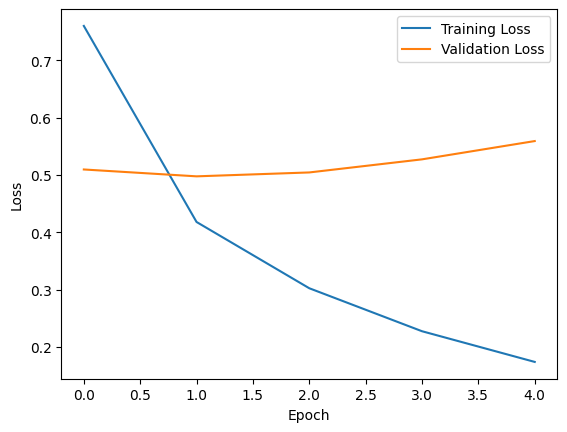

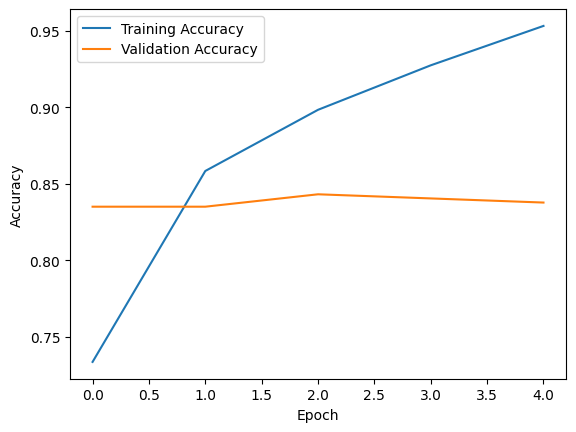

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


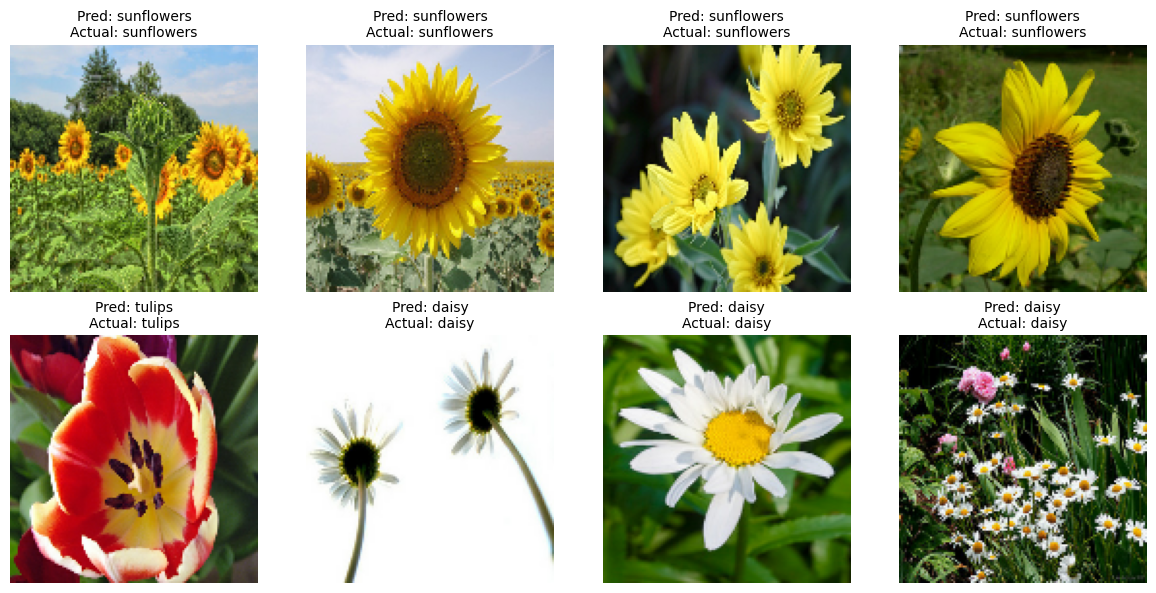

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Take exactly one batch from the evaluation dataset
for images, labels in eval_dataset.take(1):
    # Get model predictions for this batch
    batch_predictions = model.predict(images)
    predicted_indices = np.argmax(batch_predictions, axis=1)

    # Number of images in this batch
    num_images = images.shape[0]

    # Configure how many images to display per row
    num_cols = 4
    num_rows = math.ceil(num_images / num_cols)

    # Create a figure with a suitable size
    plt.figure(figsize=(12, 3 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        # Display the image
        plt.imshow(images[i].numpy())
        plt.axis('off')

        # Get predicted and actual class names
        pred_class = CLASS_NAMES[predicted_indices[i]]
        actual_class = CLASS_NAMES[labels[i].numpy()]

        # Show both predicted and actual labels as title
        plt.title(f"Pred: {pred_class}\nActual: {actual_class}", fontsize=10)

    # Adjust spacing to avoid overlapping titles, etc.
    plt.tight_layout()
    plt.show()